# Preminary operations

Let us start by importing the relevant packages

In [1]:
import gcp.bigquery as bq
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sn

## Let us explore the dataset

In [2]:
%%sql 
SELECT * FROM [google.com:ddm-connectors-demo:aw_dataset.__TABLES__];

project_id,dataset_id,table_id,creation_time,last_modified_time,row_count,size_bytes,type
google.com:ddm-connectors-demo,aw_dataset,ACCOUNT_PERFORMANCE_DEVICE,1462865492924,1462865646222,344872,213766803,1
google.com:ddm-connectors-demo,aw_dataset,ACCOUNT_PERFORMANCE_HOUR_OF_DAY,1462866241157,1462868328687,7585976,4293195830,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_DEVICE,1462882853869,1462884926720,12818403,11156943261,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_GA,1462886351515,1462888587490,12818403,11092304675,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_HOUR_OF_DAY,1462890199029,1462910444516,149020493,120843835228,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_PERFORMANCE_ANALYTICS,1462965362235,1463059120058,295426051,435427263267,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_PERFORMANCE_DEVICE,1463050362280,1463408383328,447387461,631380449113,1


## Lest us explore the table KEYWORDS_PERFORMANCE_ANALYTICS

In [3]:
%bigquery schema --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS

## Let us see how the data look like

In [4]:
%bigquery sample --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS --count 5

AccountCurrencyCode,AccountDescriptiveName,AccountTimeZoneId,ActiveViewCpm,ActiveViewCtr,ActiveViewImpressions,ActiveViewMeasurability,ActiveViewMeasurableCost,ActiveViewMeasurableImpressions,ActiveViewViewability,AdGroupId,AdGroupName,AdGroupStatus,AdNetworkType1,AdNetworkType2,AllConversionRate,AllConversions,AllConversionValue,ApprovalStatus,AverageCost,AverageCpc,AverageCpe,AverageCpm,AverageCpv,AveragePageviews,AveragePosition,AverageTimeOnSite,BaseAdGroupId,BaseCampaignId,BiddingStrategyId,BiddingStrategyName,BiddingStrategySource,BiddingStrategyType,BidType,BounceRate,CampaignId,CampaignName,CampaignStatus,ClickAssistedConversionsOverLastClickConversions,ClickAssistedConversionValue,ClickConversionRate,Clicks,ConversionRate,Conversions,ConversionValue,ConvertedClicks,Cost,CostPerAllConversion,CostPerConversion,CostPerConvertedClick,CpcBid,CpcBidSource,CpmBid,CreativeQualityScore,Criteria,CriteriaDestinationUrl,CrossDeviceConversions,Ctr,CustomerDescriptiveName,Date,DayOfWeek,EngagementRate,Engagements,EnhancedCpcEnabled,EstimatedAddClicksAtFirstPositionCpc,EstimatedAddCostAtFirstPositionCpc,ExternalCustomerId,FinalAppUrls,FinalMobileUrls,FinalUrls,FirstPageCpc,FirstPositionCpc,GmailForwards,GmailSaves,GmailSecondaryClicks,Id,ImpressionAssistedConversions,ImpressionAssistedConversionsOverLastClickConversions,ImpressionAssistedConversionValue,Impressions,InteractionRate,Interactions,IsNegative,KeywordMatchType,LabelIds,Labels,Month,MonthOfYear,PercentNewVisitors,PostClickQualityScore,PrimaryCompanyName,QualityScore,Quarter,SearchExactMatchImpressionShare,SearchImpressionShare,SearchPredictedCtr,SearchRankLostImpressionShare,Status,SystemServingStatus,TopOfPageCpc,TrackingUrlTemplate,UrlCustomParameters,ValuePerAllConversion,ValuePerConversion,ValuePerConvertedClick,VideoQuartile100Rate,VideoQuartile25Rate,VideoQuartile50Rate,VideoQuartile75Rate,VideoViewRate,VideoViews,ViewThroughConversions,Week,Year
EUR,Bravofly FR,(GMT+01:00) Paris,20000000,11.11%,9,100.00%,180000,11,81.82%,4742873125,Bravofly Misspellings,enabled,Display Network,Display Network,0.00%,0.0,0.0,--,180000,180000,0,16363636,0,1.0,1.0,0,4742873125,98913565,0,--,campaign,cpc,--,100.00%,98913565,Brand Content,enabled,0.0,0.0,0.00%,1,0.00%,0.0,0.0,0,180000,0,0,0,--,--,--,Not applicable,Content,--,0.0,9.09%,Bravofly FR,2015-09-30,Wednesday,0.00%,0,False,--,--,9348411392,--,--,--,0,0,0,0,0,3000000,0,0.0,0.0,11,9.09%,1,False,Broad,--,--,2015-09-01,September,100.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-07-01,--,--,Not applicable,--,enabled,eligible,0,--,--,0.0,0.0,0.0,0.00%,0.00%,0.00%,0.00%,0.00%,0,0,2015-09-28,2015
EUR,Bravofly Russia Voli,(GMT+01:00) Rome,0,0.00%,0,0.00%,0,0,0.00%,3639849698,Bravoavia,enabled,Search Network,Google search,0.00%,0.0,0.0,--,140000,140000,0,17500000,0,7.0,4.8,139,3639849698,108030218,0,--,campaign,cpc,--,0.00%,108030218,Brand_RU_Broad,enabled,0.0,0.0,0.00%,1,0.00%,0.0,0.0,0,140000,0,0,0,--,--,--,Not applicable,бравоавиа билеты,--,0.0,12.50%,Bravofly Russia Voli,2015-03-22,Sunday,0.00%,0,False,--,--,9837210897,--,--,--,0,0,0,0,0,33239627618,0,0.0,0.0,8,12.50%,1,False,Broad,--,--,2015-03-01,March,0.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-01-01,--,57.14%,Not applicable,42.86%,removed,--,0,--,--,0.0,0.0,0.0,0.00%,0.00%,0.00%,0.00%,0.00%,0,0,2015-03-16,2015
EUR,Bravofly Russia Voli,(GMT+01:00) Rome,0,0.00%,0,0.00%,0,0,0.00%,3639850178,Bravofly,enabled,Search Network,Search partners,0.00%,0.0,0.0,--,0,0,0,0,0,0.0,1.0,0,3639850178,108030218,0,--,campaign,cpc,--,0.00%,108030218,Brand_RU_Broad,enabled,0.0,0.0,0.00%,0,0.00%,0.0,0.0,0,0,0,0,0,--,--,--,Not applicable,bravofly,--,0.0,0.00%,Bravofly Russia Voli,2015-03-19,Thursday,0.00%,0,False,--,--,9837210897,--,--,--,0,0,0,0,0,3117710189,0,0.0,0.0,1,0.00%,0,False,Phrase,--,--,2015-03-01,March,0.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-01-01,--,100.00%,Not applicable,0.00%,remo

# Let us start checking the monthly performance on Volagratis in Italy

In [6]:
%sql --module monthly_keywords_performance
SELECT
  AccountDescriptiveName,
  CampaignName,
  AdGroupName,
  Criteria,
  KeywordMatchType,
  COUNT(Month) as MonthsWithImpressions,
  AVG(Impressions) as Impressions,
  AVG(ImpressionAssistedConversions) as ImpressionAssistedConversions,
  AVG(Clicks) as Clicks,
  AVG(ClickAssistedConversions) as ClickAssistedConversions,  
  AVG(QualityScore) as QualityScore, 
  AVG(CostEUR) as CostEUR,
  AVG(AllConversions) as AllConversions,
  AVG(Conversions) as Conversions,    
  AVG(CostPerAllConversion) as CostPerAllConversion,
  AVG(CostPerConversion) as CostPerConversion,  
  #Analytics Metrics
  AVG(BounceRate) as BounceRate,
  AVG(AveragePosition) as AveragePosition,
  AVG(AveragePageviews) as AveragePageviews,
  AVG(AverageTimeOnSite) as AverageTimeOnSite,
  AVG(PercentNewVisitors) as PercentNewVisitors,
FROM
(
SELECT
  Month,
  AccountDescriptiveName,
  CampaignName,
  AdGroupName,
  Criteria,
  KeywordMatchType,
  SUM(Impressions) as Impressions,
  SUM(ImpressionAssistedConversions) as ImpressionAssistedConversions,
  SUM(Clicks) as Clicks,
  SUM(IF(ClickAssistedConversionsOverLastClickConversions = 0, 0,
  CASE
    WHEN Conversions > 0 OR AllConversions > 0 THEN IF(AllConversions>Conversions,AllConversions,Conversions)*ClickAssistedConversionsOverLastClickConversions
    WHEN ImpressionAssistedConversions > 0 THEN ImpressionAssistedConversions*ClickAssistedConversionsOverLastClickConversions
    ELSE 1.0
  END
  )) as ClickAssistedConversions,
  
  AVG(QualityScore) as QualityScore,
  
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000 as CostEUR,
  SUM(AllConversions) as AllConversions,
  SUM(Conversions) as Conversions,  
  
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000/SUM(AllConversions) as CostPerAllConversion,
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000/SUM(Conversions) as CostPerConversion,
  
  #Analytics Metrics
  SUM(FLOAT(RTRIM(BounceRate,'%'))/100.0 * Clicks)/SUM(Clicks) as BounceRate,
  SUM(AveragePosition * Impressions)/SUM(Impressions) as AveragePosition,
  SUM(AveragePageviews * Clicks)/SUM(Clicks) as AveragePageviews,
  SUM(AverageTimeOnSite * Clicks)/SUM(Clicks) as AverageTimeOnSite,
  SUM(FLOAT(RTRIM(PercentNewVisitors,'%'))/100.0 * Clicks)/SUM(Clicks) as PercentNewVisitors,

FROM
  [google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS]
WHERE TRUE
AND NOT IsNegative
AND AdNetworkType2 = 'Google search'
AND Impressions > 0 
AND Year = 2016
AND AccountDescriptiveName IN ('Account Primario Volagratis','Volagratis Tratte Italia','Volagratis')
GROUP BY 1,2,3,4,5,6)
GROUP BY 1,2,3,4,5

In [7]:
df = bq.Query(monthly_keywords_performance).to_dataframe()

In [8]:
df.shape

(167819, 21)

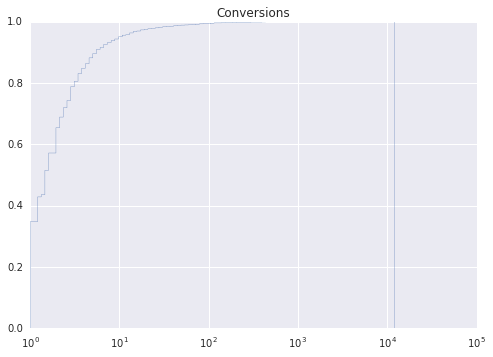

In [23]:
df.hist('Conversions',bins=(np.logspace(0,np.log10(12000),100)),
        histtype='step', cumulative=1,normed=1)
plt.gca().set_xscale("log")

array([  0.00000000e+00,   9.95218165e-02,   2.08948225e-01,
         3.29264948e-01,   4.61555811e-01,   6.07012500e-01,
         7.66945303e-01,   9.42794909e-01,   1.13614539e+00,
         1.34873846e+00,   1.58248917e+00,   1.83950319e+00,
         2.12209570e+00,   2.43281234e+00,   2.77445206e+00,
         3.15009238e+00,   3.56311712e+00,   4.01724682e+00,
         4.51657234e+00,   5.06559164e+00,   5.66925034e+00,
         6.33298625e+00,   7.06277836e+00,   7.86520070e+00,
         8.74748158e+00,   9.71756866e+00,   1.07842006e+01,
         1.19569856e+01,   1.32464883e+01,   1.46643247e+01,
         1.62232668e+01,   1.79373576e+01,   1.98220378e+01,
         2.18942849e+01,   2.41727657e+01,   2.66780050e+01,
         2.94325704e+01,   3.24612751e+01,   3.57914019e+01,
         3.94529491e+01,   4.34789001e+01,   4.79055210e+01,
         5.27726873e+01,   5.81242428e+01,   6.40083948e+01,
         7.04781484e+01,   7.75917835e+01,   8.54133806e+01,
         9.40133972e+01,